# Surprise Storm Notebook

In [36]:
# generic imports
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

### Inspection of surprise storm data

In [1]:
# data handling and visualization package
import exp

In [3]:
# loading in the data
data_df = exp.load_data_to_df('./SurpriseStorm/')

In [4]:
data_df.head()

,storm_id,relative_time,ocean,wind_speed,image
0,tst,0,1,31,"[[[tensor(97, dtype=torch.uint8), tensor(96, d..."
1,tst,1800,1,32,"[[[tensor(122, dtype=torch.uint8), tensor(127,..."
2,tst,3601,1,33,"[[[tensor(111, dtype=torch.uint8), tensor(121,..."
3,tst,5400,1,33,"[[[tensor(96, dtype=torch.uint8), tensor(106, ..."
4,tst,7200,1,34,"[[[tensor(94, dtype=torch.uint8), tensor(108, ..."


In [7]:
# ensuring that there are no duplicates in the surprise 
(data_df.duplicated() == True).value_counts

<bound method IndexOpsMixin.value_counts of 0      False
1      False
2      False
3      False
4      False
       ...  
237    False
238    False
239    False
240    False
241    False
Length: 242, dtype: bool>

In [17]:
# there are no NAN values in the time and wind speed columns
print((data_df['wind_speed'].isna() == True).value_counts)
print((data_df['relative_time'].isna() == True).value_counts)

<bound method IndexOpsMixin.value_counts of 0      False
1      False
2      False
3      False
4      False
       ...  
237    False
238    False
239    False
240    False
241    False
Name: wind_speed, Length: 242, dtype: bool>
<bound method IndexOpsMixin.value_counts of 0      False
1      False
2      False
3      False
4      False
       ...  
237    False
238    False
239    False
240    False
241    False
Name: relative_time, Length: 242, dtype: bool>


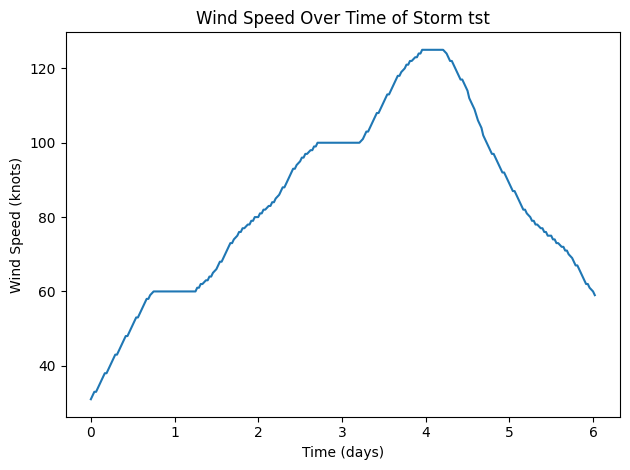

In [5]:
# plotting the windspeed of the surprise storm 
# as it progresses over time
exp.wind_speed_plot(data_df, 'tst')

## Plotting the distribution of delta t to see if it is similar to that of our previously seen storms, and it is

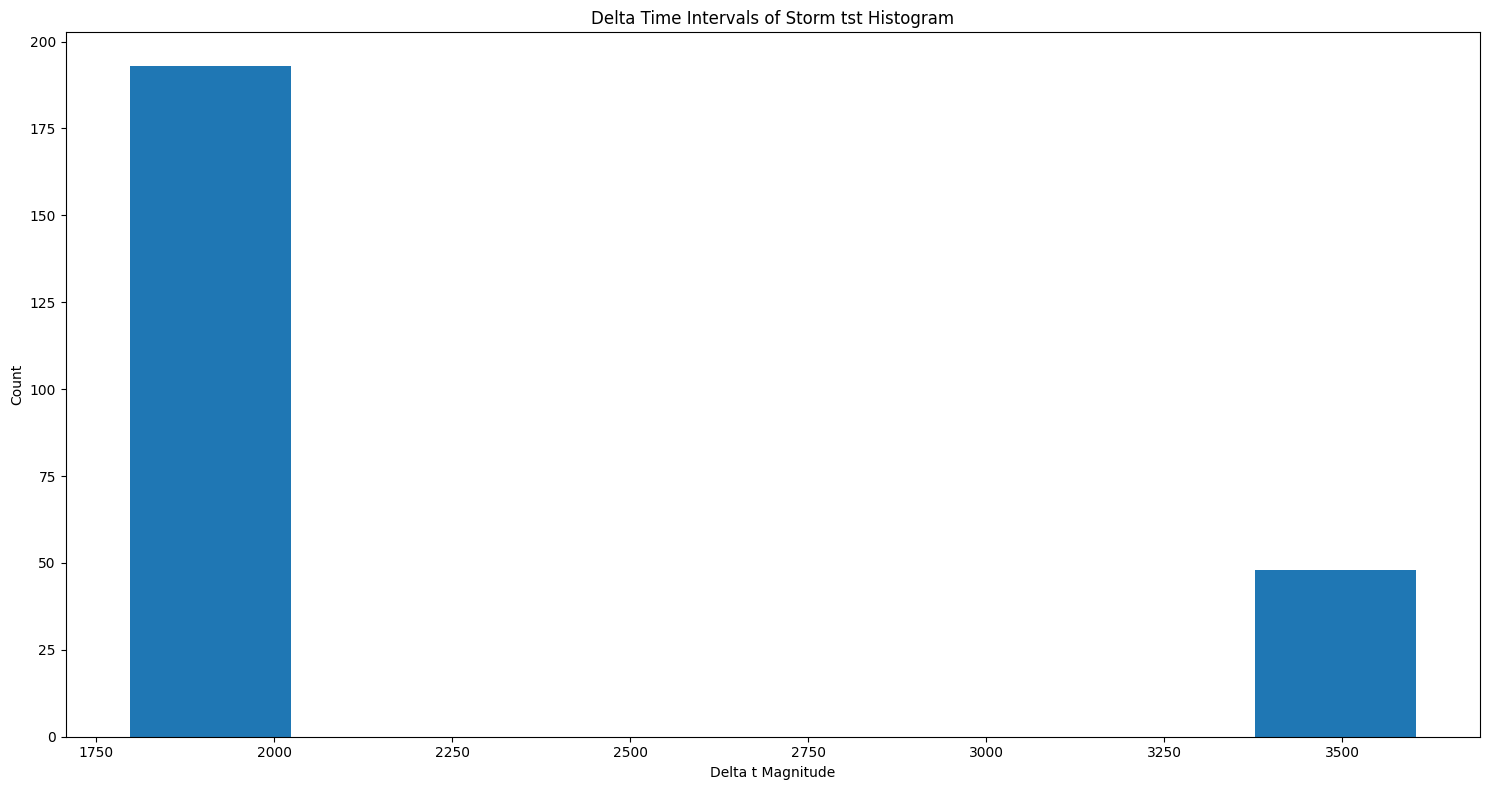

In [6]:
exp.delta_t_hist(data_df, 'tst')

## Below, we inspected all of the images. there didn't appear to be any corrupted images below are 50 of the 242 images in the suprise storm.

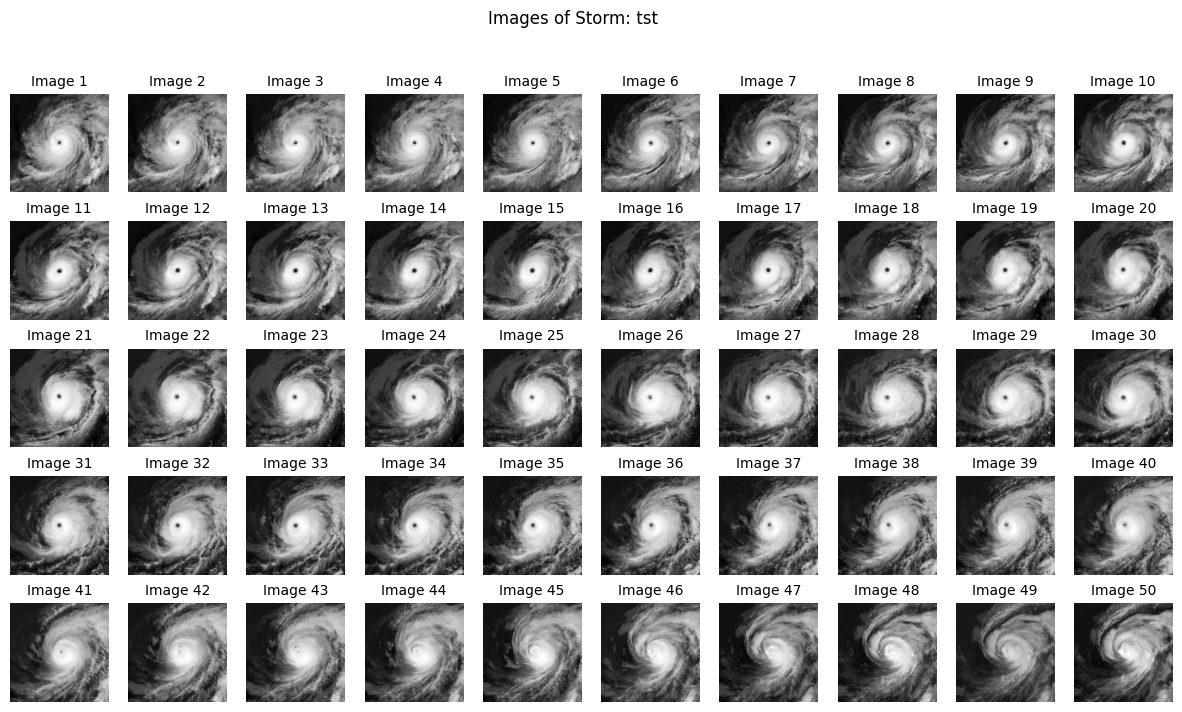

In [23]:
exp.show_multiple_images(data_df, 'tst', 150,200)

# Task 1

In [63]:
# importing package functions 
import sys
sys.path.append('./task1_package')
from dataloader import CustomDataset, train_test_split, create_combined_dataset
from model_train_test import train_model
from model import ConvLSTM, ImageSequencePredictor
from loss_func import SSIMLoss
from generate_image import predict_and_display_images
from image_comparision import compare_predicted_and_target_images

### Data preprocessing as outlined in the Task 1 Notebook

In [81]:
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((360, 360)), 
    transforms.ToTensor() 
])

folder_path = './SurpriseStorm/'

sequence = 10
combined_dataset = create_combined_dataset(folder_path, sequence, transform=transform)

train_dataset, test_dataset = train_test_split(combined_dataset, test_ratio=0.2)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Displaying Predicted images

No GPU available, running on CPU.


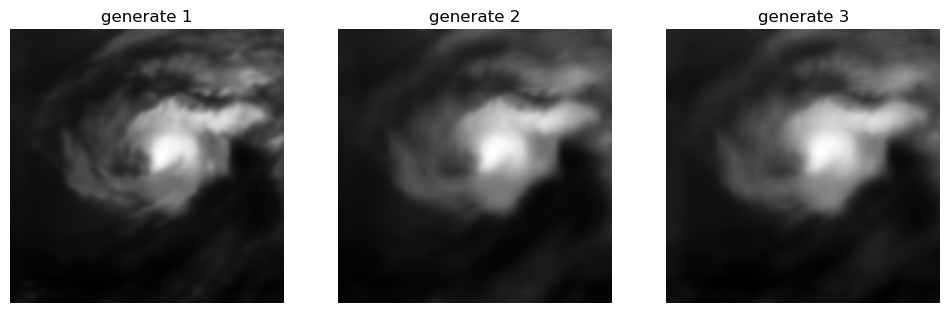

In [82]:
predict_and_display_images('./SurpriseStorm/tst','tst_', 242, 251,'./task1_package/best_model.pth')

### On initial observation, it looks like the model decent at predicting the first image in the sequence, but as it gets further away in relative time from the known data, the resolution decreases. The second and third images actually just look like blurred images of the first. The similarity between them could be due to the slow varying nature of the image sequence. Additionally, the images get blurrier because they use the previously generated image to generate the next. 

# Task 2

In [83]:
from speed import load_json_data, load_img_data, df_transformer, init_dataset, HybridNN, train_val, model_test, load_test

In [84]:
from torch.utils.data import DataLoader

### Workflow as outlined in the Task 2 Notebook

In [85]:
import torch

model = HybridNN()
model.load_state_dict(torch.load("./Task2_train_model.pth"))

<All keys matched successfully>

In [86]:
all_img_test, test_df = load_test('./SurpriseStorm/')

In [87]:
all_img_test, test_df = load_test('./SurpriseStorm/')
test_dataset = init_dataset(all_img_test, test_df, test=1)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [88]:
pred, time = model_test(model, test_loader)

--------------------------------------------                     --------------------------
Time: ['522000.00', '523800.00', '525601.00', '529199.00', '530999.00', '532799.00', '534599.00', '536398.00', '539999.00', '541799.00', '543599.00', '545399.00', '547199.00']
Prediction:  ['58.79', '58.14', '57.97', '57.14', '56.86', '56.31', '55.89', '55.26', '54.92', '54.37', '54.08', '51.23', '51.57']
--------------------------------------------                     --------------------------


In [89]:
# un-nest the lists
time = time[0]
pred = pred[0]

## Plotting the predicted points 

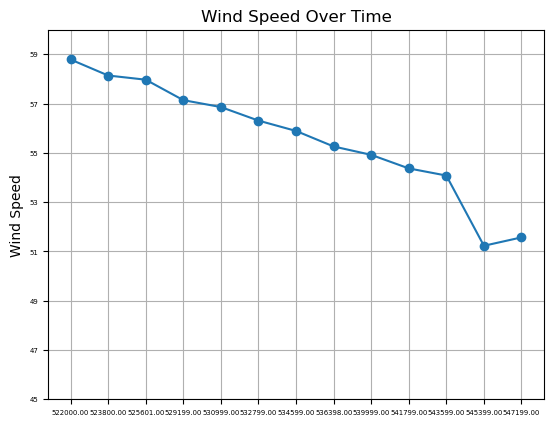

In [90]:
predictions = [float(p) for p in pred] 

fig, ax = plt.subplots()
ax.plot(time, predictions, marker='o')
plt.title('Wind Speed Over Time')
ax.set_ylabel("Wind Speed")
ax = plt.gca() 
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_ylim(45, 60)
ax.set_yticks(range(45, 61, 2)) 
plt.grid(True)
plt.show()

Above, we see 13 points, in a plot of predicted windspeed. This plot gives
 us confidence in our predictions, because the model used to generate windspeeds had an MSELoss of less that 0.02 on the validation set (before being retrained on all of the labelled data available), and we can therefore assume with reasonable confidence that the first ten predictions are relatively accurate, and the fact that the last 3 images follow the trend of the first 10 relatively closely instills confidence in our images. The wind speed does deviate a bit from the steady downward trend, which we observe due to error accumulation from the first to third generated sequential images.